In [1]:
import numpy as np


import os, glob
import astropy.io.fits as pyfits
from matplotlib import pyplot as plt
import scipy
import pandas as pd
import csv
import numpy.polynomial.polynomial as poly
from scipy.integrate import quad
# import detrend as de
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy import interpolate

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})


from astropy.io import ascii

import lightkurve as lk
from lightkurve import search_lightcurvefile

import time as ttt

# 1. Light curve preprocessing and flare candidates collection.
## 1.1 Download a TESS short cadence light curve
## 1.2 Flare candidates collection
## 1.3 Estimate the four features/characteristics of all flare candidates

# 2. Flare identification with Machine-Learning models
## 2.1 Load the models
## 2.2 Input the four features to the models for flare identification

## 1.1 Download a TESS short cadence light curve
## TIC 434103039 for the example

In [2]:
#the directory for the data storage. 
#change the directory address for your own convenience.
save_path = 'outputs'

In [3]:
#TIC	Number of Sectors	Number of Flares
#364588501	34	559
#201883033	4	110
#140045538	3	229
#441398770	3	169
#229147927	5	58
#63781635	2	17
#25118964	33	355
#231017428	4	97
#234506911	6	98
#220433363	22	845
#231914259	6	157
#365006789	3	75
#150359500	32	857
#388857263	4	117

In [4]:
TIC = 'TIC 140045538'
lcc = lk.search_lightcurve(TIC, author="SPOC", sector=1,cadence='short')

In [5]:
lcc.table["dataURL"]

<MaskedColumn name='dataURL' dtype='str73' length=1>
mast:TESS/product/tess2018206045859-s0001-0000000140045538-0120-s_lc.fits

In [6]:
search_result = lcc.download_all(download_dir=save_path)

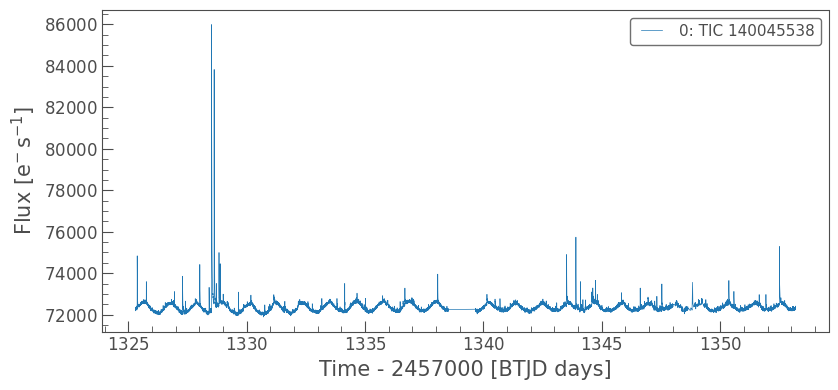

In [7]:
search_result.plot()
plt.show()

In [8]:
search_result[0].head()

<TessLightCurve length=5 LABEL="TIC 140045538" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
1325.3004032409592  7.2234797e+04 ...  2.2464739e-02  5.9155762e-02
1325.3017921432606  7.2188492e+04 ... -2.2703882e-03  2.6285123e-02
 1325.303181045562  7.2207766e+04 ... -6.7850789e-03  2.2310857e-02
1325.3045699478632  7.2235648e+04 ... -7.8595541e-03  1.0938278e-02
 1325.305958849699  7.2302422e+04 ... -1.1981726e-02  1.1425514e-02

In [9]:
# time0.value

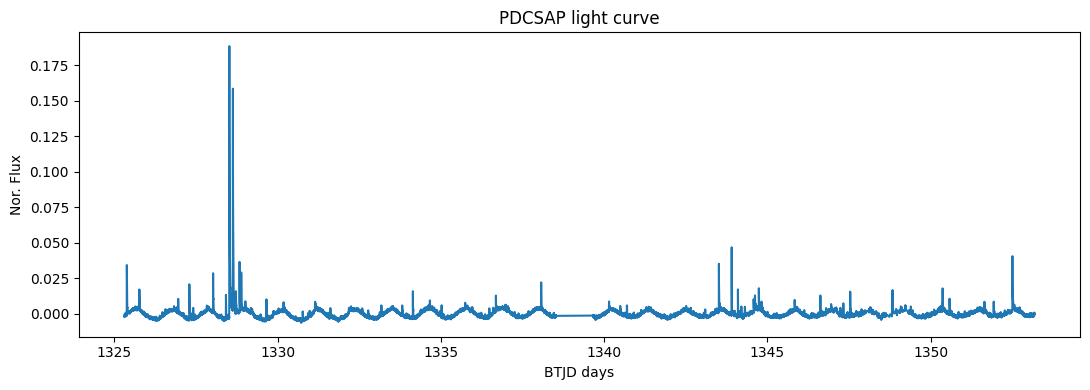

In [10]:
#pdcsap normalized light curve
plt.figure(figsize=(11,4))
plt.title('PDCSAP light curve')
time0 = search_result[0]['time'][search_result[0]['quality']==0].value
pdc0 = search_result[0]['pdcsap_flux'][search_result[0]['quality']==0].value 
pdc0 = np.array(pdc0) 

nor_pdc0 = pdc0 / np.nanmedian(pdc0)  - 1
plt.plot(time0, nor_pdc0)


plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [11]:
#detrend the light curve by using the "flatten" funciton for 2 iteration
#the users can detrend the light curves with their own prefer methods

flatten_lc = search_result[0].flatten(window_length=201, polyorder=1, \
return_trend=False, break_tolerance=5, niters=2, \
sigma=3, mask = search_result[0]['quality'] != 0 ).to_pandas()
flatten_lc = flatten_lc.reset_index(drop=0)


fmean4 = np.nanmean(flatten_lc['flux'][flatten_lc['quality']==0])
fstd4 = np.nanstd(flatten_lc['flux'][flatten_lc['quality']==0])
fmedian4 = np.nanmedian(flatten_lc['flux'][flatten_lc['quality']==0])
fmad4 = np.nansum(abs(flatten_lc['flux'][flatten_lc['quality']==0]-fmedian4))/len(flatten_lc['flux'][flatten_lc['quality']==0])

mask1 = np.abs(flatten_lc['flux'] - 1) > 3 * fmad4
# mask1 = flatten_lc['flux'] > fmedian4 + 3 * fmad4

# mask1 = flatten_lc['flux'] > fmedian4 + 3 * fstd4
mask1 = mask1.values


#second flatten
mask2 = []
for i,v in enumerate(search_result[0]['quality'] != 0 ):
    if v == mask1[i]: 
        if v == False:
            mask2.append(False)

        if v == True:
            mask2.append(True)

    if v != mask1[i]:
        mask2.append(True)

mask2 = np.array(mask2)


flatten_lc2 = search_result[0].flatten(window_length=111, polyorder=2, \
                                      return_trend=False, break_tolerance=5, niters=5, \
                                      sigma=3, mask= mask2 ).to_pandas()
flatten_lc2 = flatten_lc2.reset_index(drop=0)

In [12]:
flatten_lc2.head()

time      flux  flux_err  timecorr  cadenceno  centroid_col  \
0  1325.300403  0.999090   0.00043  0.004668      70445    528.816611   
1  1325.301792  0.998449   0.00043  0.004668      70446    528.792890   
2  1325.303181  0.998716   0.00043  0.004669      70447    528.788629   
3  1325.304570  0.999101   0.00043  0.004669      70448    528.787195   
4  1325.305959  1.000025   0.00043  0.004669      70449    528.783770   

   centroid_row      sap_flux  sap_flux_err      sap_bkg  ...  psf_centr1  \
0   1068.567149  69163.593750     29.485779  2447.421387  ...         NaN   
1   1068.535585  69151.296875     29.482016  2457.644043  ...         NaN   
2   1068.531248  69181.195312     29.487997  2453.665771  ...         NaN   
3   1068.520758  69217.093750     29.501167  2470.340820  ...         NaN   
4   1068.521487  69257.984375     29.500063  2455.480957  ...         NaN   

   psf_centr1_err  psf_centr2  psf_centr2_err  mom_centr1  mom_centr1_err  \
0             NaN         NaN             NaN  528.816611        0.000336   
1             NaN         NaN             NaN  528.792890        0.000337   
2             NaN         NaN             NaN  528.788629        0.000337   
3             NaN         NaN             NaN  528.787195        0.000337   
4             NaN         NaN             NaN  528.783770        0.000337   

    mom_centr2  mom_centr2_err  pos_corr1  pos_corr2  
0  1068.567149        0.000356   0.022465   0.059156  
1  1068.535585        0.000356  -0.002270   0.026285  
2  1068.531248        0.000357  -0.006785   0.022311  
3  1068.520758        0.000357  -0.007860   0.010938  
4  1068.521487        0.000357  -0.011982   0.011426  

[5 rows x 24 columns]

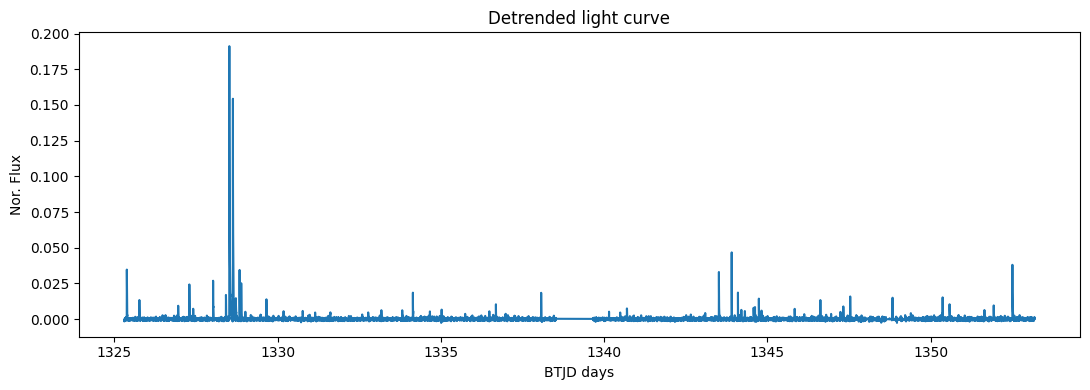

In [13]:
plt.figure(figsize=(11,4))

plt.title('Detrended light curve')

time1 = flatten_lc2['time'][flatten_lc2['quality']==0]
nor_pdc1 = flatten_lc2['flux'][flatten_lc2['quality']==0] -  1

plt.plot(time1, nor_pdc1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [14]:
len(time0), len(time1)

(18230, 18230)

In [15]:
# detrend_fits = nor_pdc0 - nor_pdc1 

# plt.figure(figsize=(11,4))
# plt.plot(time0, nor_pdc0)

# plt.plot(time0, detrend_fits)
# # plt.xlim(1375,)
# plt.xlabel('BTJD days')
# plt.ylabel('Nor. Flux')
# plt.show()

## 1.2 Flare candidates collection

Please read Section 2.1 in the paper for the criteria for flare canddiates selection.

In [16]:
fmean3 = np.nanmean(nor_pdc1)
fstd3 = np.nanstd(nor_pdc1)
fmedian3 = np.nanmedian(nor_pdc1) 
fmad3 = np.nansum(abs(nor_pdc1-fmedian3))\
/len(nor_pdc1)
mask3 = np.abs(nor_pdc1) > 3 * fstd3
mask3 = mask3.values

fmean4 = np.nanmean(np.ma.array(nor_pdc1.values, mask=mask3)) 
fmedian4 = np.nanmedian(np.ma.array(nor_pdc1.values, mask=mask3)) 
fstd4 = np.nanstd(np.ma.array(nor_pdc1.values, mask=mask3))

nor_pdc2 = nor_pdc1 - fmedian4

from itertools import groupby
from operator import itemgetter

time1 = time1.reset_index(drop=1)
nor_pdc2 = nor_pdc2.reset_index(drop=1)
# collect flare candidate
time1_sel3 = time1[nor_pdc2 >   1 * fstd4]

ind_f3 = time1_sel3.index

ind_f_cadi = []
for k, g in groupby(enumerate(ind_f3), lambda ix : ix[0] - ix[1]):
#     print( list(map(itemgetter(1), g)))
    ind_f_cadi.append(list(map(itemgetter(1), g)))

/Users/kyrabettwy/venvs/tf213/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [17]:
print('sigma of detrended light curve is ', fstd4)

sigma of detrended light curve is  0.0009397177743685514


In [18]:
ind_f = []
ind_f_cadi3 = []
# ind_f_cadi4 = []

flare_time_start = []
flare_time_end = []
flare_time_peak = []

flare_peak_amplitude = []



for i,v in enumerate(ind_f_cadi):
    ind_f_cand = ind_f_cadi[i]
    if len(ind_f_cand) >= 3:
        try:
            flare_time_start.append( time1[ind_f_cand[0]-1] ) 
            flare_time_end.append( time1[ind_f_cand[-1]+1])
            flare_time_peak.\
            append(time1.loc[ind_f_cand][nor_pdc2.loc[ind_f_cand] == np.max(nor_pdc2.loc[ind_f_cand])].values[0])
            
            flare_peak_amplitude.append(np.max(nor_pdc2.loc[ind_f_cand]))
            
            ind_f.append(i)
            ind_f_cadi3.append(ind_f_cand)


        except ValueError and KeyError:
            pass

In [19]:
print(len(ind_f), 'flare candidates')

130 flare candidates


In [20]:
# %matplotlib notebook

In [21]:
time1.loc[v[0]-1 : v[-1]+1].values

array([1353.17660999, 1353.17799885, 1353.1793877 ])

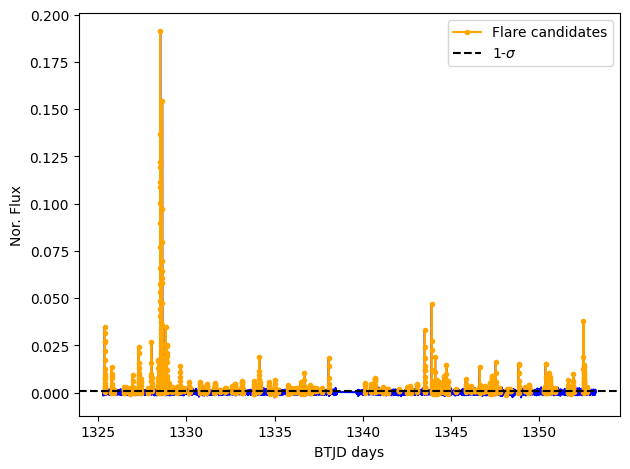

In [22]:
#normalized light curves
plt.plot(time1, nor_pdc2, color='b')

time1_candidates = []
nor_pdc2_candidates = []
#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if i ==0:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
                 '.-',color='orange', label='Flare candidates')
    else:
        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')
    
    time1_candidates.append(time1.loc[v[0]-1 : v[-1]+1].values)
    nor_pdc2_candidates.append(nor_pdc2.loc[v[0]-1 : v[-1]+1].values)

plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

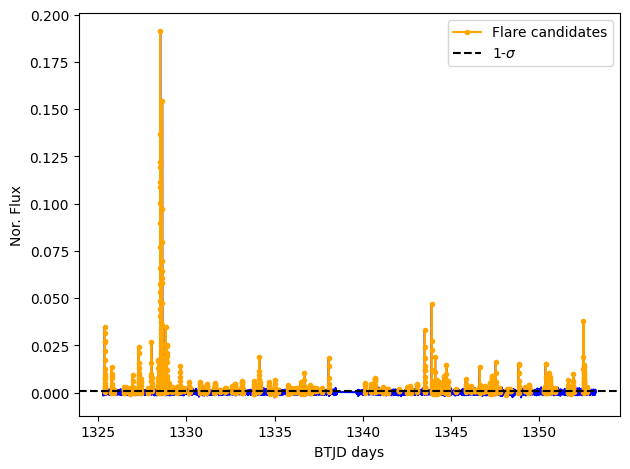

In [23]:
#normalized light curves
plt.plot(time1, nor_pdc2, color='b')

#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if i ==0:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
                 '.-',color='orange', label='Flare candidates')
    else:
        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')


plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

## 1.3 Estimate the four features/characteristics of all flare candidates

### 1. The duration of the flare candidate ($\delta t$) in days.
### 2. The impulsive-decay time ratio ($\delta t_1 / \delta t_2$).
### 3. The upper-to-lower equivalent duration ratio ($ED_1 / ED_2$).
### 4. The peak amplitude signal-to-noise ratio ($A_f / \sigma$).

Please read the Section 2.1, Section 2.2, and Figure 1 in our paper for more specific details.


In [24]:
# 1. duration delta_t in days
flare_time_end = np.array(flare_time_end)
flare_time_start = np.array(flare_time_start)

delta_t = flare_time_end - flare_time_start

In [25]:
# delta_t

In [26]:
# 2. impulsive-decay time ratio (delta_t1/delta_t2)
flare_time_peak  = np.array(flare_time_peak)

delta_t1 = flare_time_peak - flare_time_start
delta_t2 = flare_time_end - flare_time_peak


delta_t1_to_delta_t2 = delta_t1 / delta_t2

In [27]:
# delta_t1_to_delta_t2

In [28]:
#3. The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
# The equation of equivalent duration
def ED(x, y): #equivalent duration in second
    
    ef = 0
    for i2,v2 in enumerate(x):
        try:
#             print(x[i2], x[i2+1])

            '''1-D linear fitting'''
            coefs = poly.polyfit(x[i2:i2+2], y[i2:i2+2] ,1)

            '''1-D linear function for equivalent duration (ED) flare energy estimate method'''
            ew_flare_1 = lambda x :  coefs[1]*x+coefs[0]

            '''Integrate 1-D linear function for ED'''
            e1 = quad(ew_flare_1, x[i2], x[i2+1])
#             print(e1[0])
            ef+=e1[0]
        except IndexError:
            pass
        
    return ef * 86400

In [29]:
nor_pdc2_candidates[0]

array([0.00043423, 0.02701726, 0.03472451, 0.03139561, 0.02673958,
       0.0221887 , 0.01712276, 0.01251952, 0.00986667, 0.008329  ,
       0.00706455, 0.00488747, 0.00264224, 0.00331252, 0.00291433,
       0.00240343, 0.00123721, 0.00136517, 0.00098269, 0.00105546,
       0.00058833])

In [30]:
ED_all = []
ED1 = []
ED2 = []

for i,v in enumerate(nor_pdc2_candidates):
    time_fcad = time1_candidates[i]
    norf_fcd = nor_pdc2_candidates[i]
    amp_peak = flare_peak_amplitude[i]

    f = interpolate.interp1d(time_fcad, norf_fcd)
    t_array = np.linspace(np.nanmin(time_fcad), np.nanmax(time_fcad), 100)
    f_array = f(t_array)
    a = ED(t_array,  f_array)
    a2 = ED(t_array[ f_array < amp_peak/2],   f_array[ f_array < amp_peak/2 ])
    a1 = a - a2
    
    ED_all.append(a)
    ED1.append(a1)
    ED2.append(a2)

/Users/kyrabettwy/venvs/tf213/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [31]:
len(ED_all)

130

In [32]:
# ED1

In [33]:
# ED2

In [34]:
# The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
ED1 = np.array(ED1)
ED2 = np.array(ED2)

ED1_to_ED2 = ED1 / ED2

/var/folders/3l/xp5scxws3kn9d72khd66rw7w0000gn/T/ipykernel_26240/1809543040.py:5: RuntimeWarning: divide by zero encountered in divide
  ED1_to_ED2 = ED1 / ED2


In [35]:
# ED1_to_ED2

In [36]:
#4. Peak amplitude to noise ratio 
flare_peak_amplitude = np.array(flare_peak_amplitude)
amp_to_std_ratio = flare_peak_amplitude / fstd4

In [37]:
# flare_peak_amplitude

In [38]:
# amp_to_std_ratio

In [39]:
# now you have all four features for all flare candidates

# 1. duration delta_t in days
delta_t
# 2. impulsive-decay time ratio (delta_t1/delta_t2)
delta_t1_to_delta_t2
#3. The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
ED1_to_ED2
#4. Peak amplitude to noise ratio 
amp_to_std_ratio

array([ 36.95205904,  14.28044815,   1.40005228,   2.94046453,
         3.04319487,   2.63581453,   1.82447181,   1.8303464 ,
         2.75526142,   1.99078164,  10.01033858,   1.82053056,
        25.88313267,   2.6859055 ,   7.77865462,   2.69443262,
        28.65563003,  18.06954982,   2.01532595, 203.38957458,
       164.2192504 ,  15.64633594,   1.5893433 ,  36.67989282,
        26.765273  ,   5.54429886,   3.14695631,   3.33327537,
        14.80810663,   2.58080332,   5.94944121,   6.15262712,
         2.69078861,   3.31573951,   4.97788235,   1.61582239,
         2.53109817,   5.1005707 ,   1.47006113,   2.45386866,
         2.35826041,   3.51251232,   5.0380623 ,   2.74699907,
         6.70027943,   6.6521977 ,   2.76417026,   2.45976232,
        19.76608575,   5.79087692,   2.18541528,   2.45373326,
         7.13627023,   2.10333018,   1.60493175,   3.99761521,
         2.14833336,   2.79501518,   2.10956724,   2.82717701,
         2.46134411,   5.86644096,   3.25882506,  11.09


# 2. Flare identification with Machine-Learning models
## 2.1 Load the models
## 2.2 Input the four features to the models for flare identification

## 2.1 Load the models


In [40]:
#custom f1_score for our Deep Neural Network model
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

In [41]:
#models are stored in the directory "ML_models"

In [42]:
# cd ML_models/

In [43]:
#RandomForest

import joblib

loaded_model = joblib.load('RandomForestClassifier_flare_classification-by-Lin.pkl') #ver 13 is better than 14

# Now 'loaded_model' is the trained Random Forest model

# Deep Neural Network
from tensorflow.keras.models import load_model

model_dnn = load_model(os.path.join("DNNClassifier_flare_classification-by-Lin.keras"), \
                       custom_objects={'f1_score': f1_score}, compile=False)

#XGBoost

from xgboost import XGBClassifier
loaded_model_xgboost =  XGBClassifier()

loaded_model_xgboost.load_model('XGBoostClassifier_flare_classification-by-Lin.json')

2025-10-13 23:00:21.452232: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-10-13 23:00:21.452254: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-10-13 23:00:21.452258: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-10-13 23:00:21.452281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-13 23:00:21.452292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [44]:
#RandomForest
import joblib

loaded_model = joblib.load('RandomForestClassifier_flare_classification-by-Lin.pkl') # ver 13 is better than 14

In [45]:
#XGBoost
from xgboost import XGBClassifier
loaded_model_xgboost =  XGBClassifier()

loaded_model_xgboost.load_model('XGBoostClassifier_flare_classification-by-Lin.json')

#model xgboost.fit(X_train, Y_train), easy to train XGBoost model w 3 lines of python

## 2.2 Input the four features to the models for flare identification

Gather the four features into a table

In [46]:
input_candidates = \
pd.DataFrame([], columns=['delta_t', 't1/t2', 'ED1/ED2', 'Af/STD', 'class'])

input_candidates['delta_t'] = delta_t
input_candidates['t1/t2'] = delta_t1_to_delta_t2
input_candidates['ED1/ED2'] = ED1_to_ED2
input_candidates['Af/STD'] = amp_to_std_ratio

input_candidates.head()

delta_t     t1/t2   ED1/ED2     Af/STD class
0  0.027778  0.111111  0.342033  36.952059   NaN
1  0.012500  0.285714  0.321555  14.280448   NaN
2  0.005556  1.000000  0.636404   1.400052   NaN
3  0.006945  0.666667  0.373917   2.940465   NaN
4  0.008333  0.500000  0.270599   3.043195   NaN

In [47]:
#Input format
X = input_candidates.values[ :, [0,1,2,3] ]

In [48]:
X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
X = np.clip(X, -1e6, 1e6)

In [49]:
#Models' predicitons

#Random Forest
y_pred_rf = loaded_model.predict(X)
y_predv2_rf = np.argmax(y_pred_rf,axis=1) 


#DNN 
X1 = np.asarray(X).astype(np.float64)
y_pred_dnn = model_dnn.predict(X1)
# y_pred_dnn_v2 = np.argmax(y_pred_dnn,axis=1) 
threshold = 0.5

y_pred_dnn_v2 = []
for i,v in enumerate(y_pred_dnn):
    try:
        y_pred_dnn_v2.append(np.where(y_pred_dnn[i]> threshold) [0][0])
    except IndexError:
        y_pred_dnn_v2.append(0)
y_pred_dnn_v2 = np.array(y_pred_dnn_v2)


#XGBoost
y_pred_xgbr = loaded_model_xgboost.predict(X)
y_pred_xgbr_v2 = np.argmax(y_pred_xgbr,axis=1) #classifier

2025-10-13 23:00:23.336837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 66ms/step


In [50]:
y_predv2_rf

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1])

Flare identification with the models

In [51]:
y_pred_dnn_v2

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
y_pred_xgbr_v2

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0])

In [53]:
#Three models' prediction voting

#combine the prediction from the three models
combined_pred = np.column_stack((y_predv2_rf, y_pred_dnn_v2, y_pred_xgbr_v2))


In [54]:
# combined_pred

In [55]:
from statistics import mode

votes = np.array(list(map(mode, combined_pred)))

In [56]:
print("Number of RF's flares:", len(votes[y_predv2_rf==1]))
print("Number of DNN's flares:", len(votes[y_pred_dnn_v2==1]))
print("Number of XGB's flares:", len(votes[y_pred_xgbr_v2==1]))
print("Number of Voted flares:", len(votes[votes==1]))

Number of RF's flares: 74
Number of DNN's flares: 119
Number of XGB's flares: 59
Number of Voted flares: 74


In [57]:
input_candidates['F_amp'] = flare_peak_amplitude
input_candidates['time_start(BTJD)'] = flare_time_start
input_candidates['time_peak(BTJD)'] = flare_time_peak
input_candidates['time_end(BTJD)'] = flare_time_end
input_candidates['class'] = votes

In [58]:
#you can save this table for the further analysis
vote_flares_results = input_candidates[input_candidates['class']==1].reset_index(drop=1)
vote_flares_results.head()

delta_t     t1/t2   ED1/ED2     Af/STD  class     F_amp  time_start(BTJD)  \
0  0.027778  0.111111  0.342033  36.952059      1  0.034725       1325.375404   
1  0.012500  0.285714  0.321555  14.280448      1  0.013420       1325.760130   
2  0.005556  1.000000  0.387483   2.755261      1  0.002589       1326.907361   
3  0.009722  0.166667  0.254713  10.010339      1  0.009407       1326.950417   
4  0.027778  0.176471  0.228560  25.883133      1  0.024323       1327.289309   

   time_peak(BTJD)  time_end(BTJD)  
0      1325.378182     1325.403182  
1      1325.762907     1325.772630  
2      1326.910139     1326.912917  
3      1326.951806     1326.960140  
4      1327.293476     1327.317087

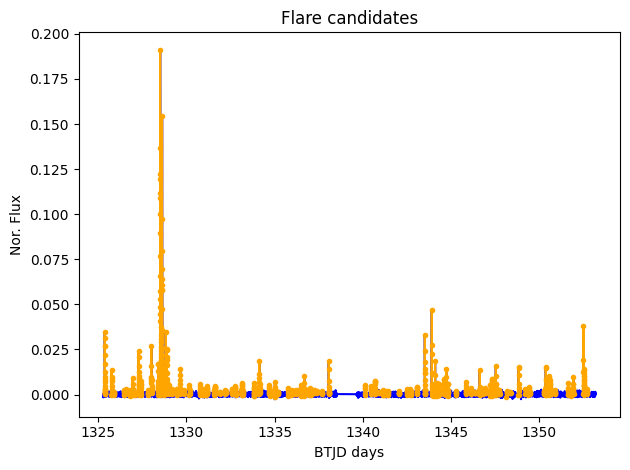

In [59]:
#normalized light curves
plt.title('Flare candidates')

plt.plot(time1, nor_pdc2, color='b')


#flare candidates
for i,v in enumerate(ind_f_cadi3):

    plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
     '.-',color='orange')


# plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

# plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

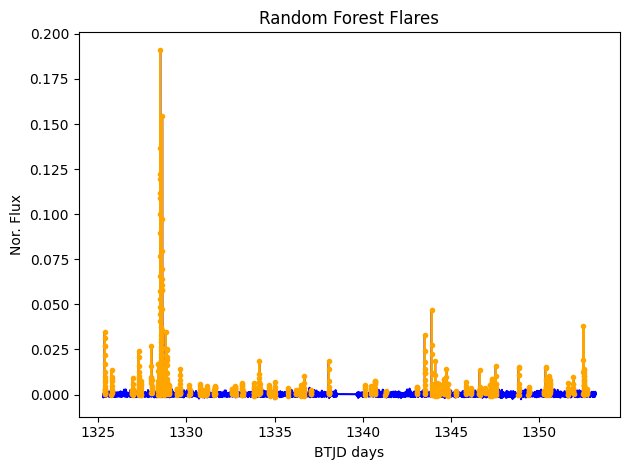

In [60]:
#normalized light curves
plt.title('Random Forest Flares')
plt.plot(time1, nor_pdc2, color='b')


#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if y_predv2_rf[i] == 1:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')


# plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

# plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

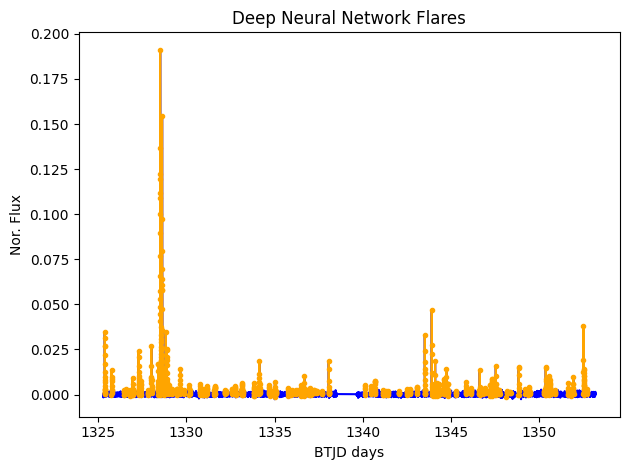

In [61]:
#normalized light curves
plt.title('Deep Neural Network Flares')
plt.plot(time1, nor_pdc2, color='b')


#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if y_pred_dnn_v2[i] == 1:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')


# plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

# plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

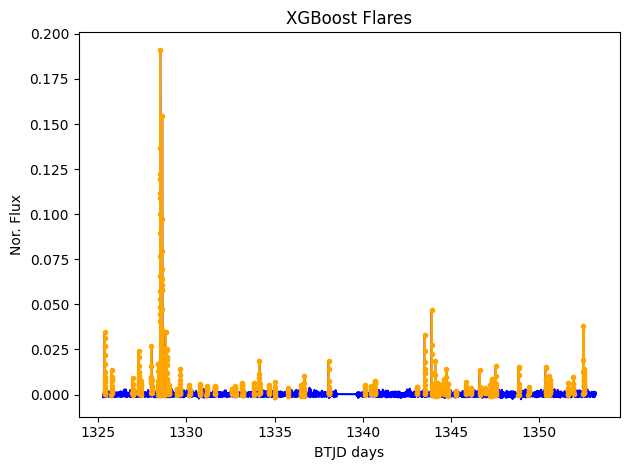

In [62]:
#normalized light curves
plt.title('XGBoost Flares')
plt.plot(time1, nor_pdc2, color='b')


#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if y_pred_xgbr_v2[i] == 1:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')


# plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

# plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

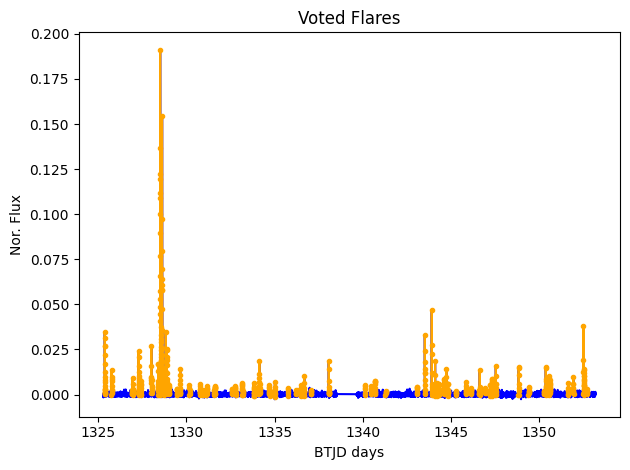

In [63]:
#normalized light curves
plt.title('Voted Flares')
plt.plot(time1, nor_pdc2, color='b')


#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if votes[i] == 1:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')


# plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

# plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [64]:
#merged_gunther_1400.to_csv("merged_gunther_1400.csv")

In [65]:
## installing the gunther flares for comparison for sector 1 

merged_gunther_1400 = pd.read_csv("merged_gunther_1400.csv")
#merged_gunther_1400 = gunther_values[gunther_values["TIC"] == 140045538]
merged_gunther_1400 = merged_gunther_1400.copy()
merged_gunther_1400["t_peak"] = merged_gunther_1400["tpeak"] - 2457000
merged_gunther_1400

Unnamed: 0        TIC  Outbst  Flare         tpeak   e_tpeak   E_tpeak  \
0         1794  140045538       1      1  2.458325e+06  0.000023  0.000027   
1         1795  140045538       1      2  2.458325e+06  0.000071  0.000072   
2         1796  140045538       2      1  2.458326e+06  0.000079  0.000083   
3         1797  140045538       4      1  2.458327e+06  0.000089  0.000077   
4         1798  140045538       4      2  2.458327e+06  0.000467  0.000578   
..         ...        ...     ...    ...           ...       ...       ...   
87        1881  140045538      55      1  2.458351e+06  0.000113  0.000143   
88        1882  140045538      56      1  2.458352e+06  0.000196  0.000198   
89        1883  140045538      57      1  2.458352e+06  0.000107  0.000113   
90        1884  140045538      58      1  2.458353e+06  0.000029  0.000030   
91        1885  140045538      58      2  2.458353e+06  0.000623  0.000722   

        Amp    e_Amp    E_Amp   FWHMdt  e_FWHMdt  E_FWHMdt          Ebol  \
0   0.04692  0.00250  0.00315  0.00148   0.00019   0.00020  6.849000e+32   
1   0.02298  0.00097  0.00099  0.00604   0.00036   0.00035  1.215000e+33   
2   0.01706  0.00061  0.00064  0.00368   0.00029   0.00030  5.831000e+32   
3   0.01400  0.00151  0.00271  0.00136   0.00036   0.00037  1.721000e+32   
4   0.00413  0.00100  0.00122  0.00637   0.00357   0.00552  2.545000e+32   
..      ...      ...      ...      ...       ...       ...           ...   
87  0.01189  0.00073  0.00073  0.00425   0.00054   0.00061  5.259000e+32   
88  0.00706  0.00068  0.00072  0.00356   0.00069   0.00079  2.831000e+32   
89  0.00994  0.00050  0.00053  0.00534   0.00054   0.00053  5.174000e+32   
90  0.05174  0.00182  0.00203  0.00145   0.00012   0.00011  6.581000e+32   
91  0.00868  0.00200  0.00254  0.01904   0.00481   0.01111  1.618000e+33   

          e_Ebol        E_Ebol          MCME        e_MCME        E_MCME  \
0   6.542000e+31  6.193000e+31  7.271000e+19  6.949000e+19  8.534000e+20   
1   9.217000e+31  1.067000e+32  9.315000e+19  9.045000e+19  1.994000e+21   
2   3.484000e+31  3.885000e+31  7.669000e+19  7.282000e+19  1.570000e+21   
3   2.284000e+31  2.920000e+31  5.610000e+19  5.330000e+19  8.042000e+20   
4   1.450000e+32  1.598000e+32  2.644000e+19  2.461000e+19  5.018000e+20   
..           ...           ...           ...           ...           ...   
87  8.211000e+31  5.929000e+31  7.611000e+19  6.908000e+19  1.840000e+21   
88  5.138000e+31  6.428000e+31  4.350000e+19  4.092000e+19  9.090000e+20   
89  4.699000e+31  2.957000e+31  5.810000e+19  5.519000e+19  6.898000e+20   
90  2.508000e+31  4.061000e+31  8.033000e+19  7.583000e+19  1.348000e+21   
91  5.800000e+32  1.339000e+33  1.502000e+20  1.478000e+20  1.395000e+21   

         t_peak  
0   1325.377294  
1   1325.380283  
2   1325.762618  
3   1326.951894  
4   1326.910894  
..          ...  
87  1350.578834  
88  1351.647574  
89  1351.931778  
90  1352.503874  
91  1352.510028  

[92 rows x 20 columns]

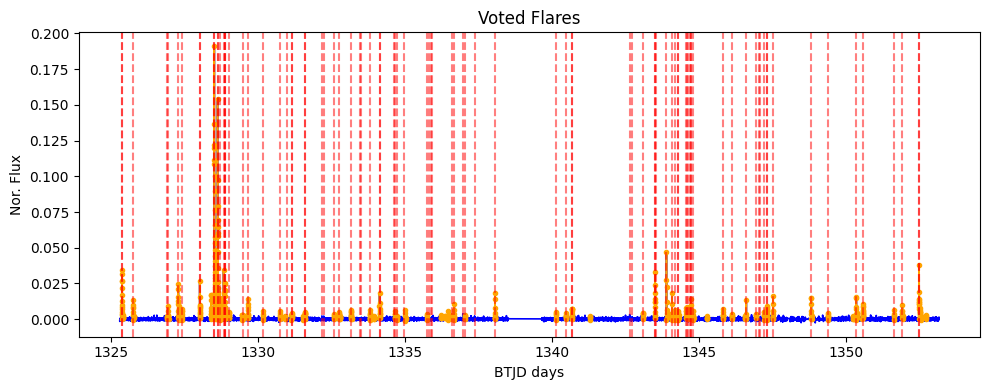

In [68]:
plt.figure(figsize=(10, 4))

plt.title('Voted Flares')
plt.plot(time1, nor_pdc2, color='b', linewidth=1.2)

#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if votes[i] == 1:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange', linewidth=1.2)

for t in merged_gunther_1400["t_peak"]:
    plt.axvline(t, ls="--", color="red", alpha=0.5)

# plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

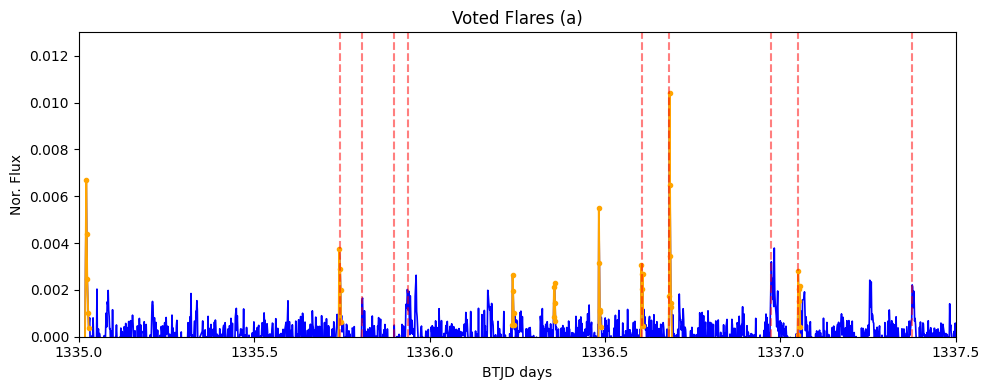

In [69]:
plt.figure(figsize=(10, 4))

plt.title('Voted Flares (a)')
plt.plot(time1, nor_pdc2, color='b', linewidth=1.2)


#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if votes[i] == 1:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange', linewidth=1.4)


#plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

for t in merged_gunther_1400["t_peak"]:
    plt.axvline(t, ls="--", color="red", alpha=0.5)

plt.xlim(1335, 1337.5)
plt.ylim(0, 0.013)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

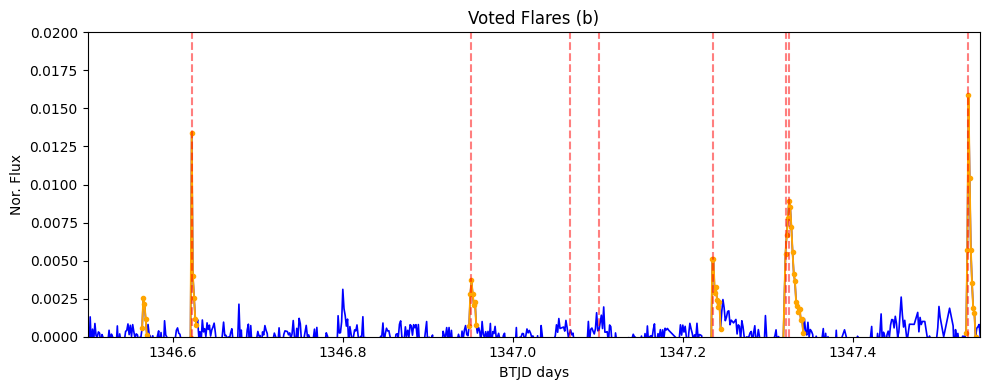

In [70]:
plt.figure(figsize=(10, 4))

plt.title('Voted Flares (b)')
plt.plot(time1, nor_pdc2, color='b', linewidth=1.2)


#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if votes[i] == 1:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange', linewidth=1.4)


for t in merged_gunther_1400["t_peak"]:
    plt.axvline(t, ls="--", color="red", alpha=0.5)

#plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

plt.xlim(1346.5, 1347.55)
plt.ylim(0, 0.02)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [71]:
merged_gunther_1400

Unnamed: 0        TIC  Outbst  Flare         tpeak   e_tpeak   E_tpeak  \
0         1794  140045538       1      1  2.458325e+06  0.000023  0.000027   
1         1795  140045538       1      2  2.458325e+06  0.000071  0.000072   
2         1796  140045538       2      1  2.458326e+06  0.000079  0.000083   
3         1797  140045538       4      1  2.458327e+06  0.000089  0.000077   
4         1798  140045538       4      2  2.458327e+06  0.000467  0.000578   
..         ...        ...     ...    ...           ...       ...       ...   
87        1881  140045538      55      1  2.458351e+06  0.000113  0.000143   
88        1882  140045538      56      1  2.458352e+06  0.000196  0.000198   
89        1883  140045538      57      1  2.458352e+06  0.000107  0.000113   
90        1884  140045538      58      1  2.458353e+06  0.000029  0.000030   
91        1885  140045538      58      2  2.458353e+06  0.000623  0.000722   

        Amp    e_Amp    E_Amp   FWHMdt  e_FWHMdt  E_FWHMdt          Ebol  \
0   0.04692  0.00250  0.00315  0.00148   0.00019   0.00020  6.849000e+32   
1   0.02298  0.00097  0.00099  0.00604   0.00036   0.00035  1.215000e+33   
2   0.01706  0.00061  0.00064  0.00368   0.00029   0.00030  5.831000e+32   
3   0.01400  0.00151  0.00271  0.00136   0.00036   0.00037  1.721000e+32   
4   0.00413  0.00100  0.00122  0.00637   0.00357   0.00552  2.545000e+32   
..      ...      ...      ...      ...       ...       ...           ...   
87  0.01189  0.00073  0.00073  0.00425   0.00054   0.00061  5.259000e+32   
88  0.00706  0.00068  0.00072  0.00356   0.00069   0.00079  2.831000e+32   
89  0.00994  0.00050  0.00053  0.00534   0.00054   0.00053  5.174000e+32   
90  0.05174  0.00182  0.00203  0.00145   0.00012   0.00011  6.581000e+32   
91  0.00868  0.00200  0.00254  0.01904   0.00481   0.01111  1.618000e+33   

          e_Ebol        E_Ebol          MCME        e_MCME        E_MCME  \
0   6.542000e+31  6.193000e+31  7.271000e+19  6.949000e+19  8.534000e+20   
1   9.217000e+31  1.067000e+32  9.315000e+19  9.045000e+19  1.994000e+21   
2   3.484000e+31  3.885000e+31  7.669000e+19  7.282000e+19  1.570000e+21   
3   2.284000e+31  2.920000e+31  5.610000e+19  5.330000e+19  8.042000e+20   
4   1.450000e+32  1.598000e+32  2.644000e+19  2.461000e+19  5.018000e+20   
..           ...           ...           ...           ...           ...   
87  8.211000e+31  5.929000e+31  7.611000e+19  6.908000e+19  1.840000e+21   
88  5.138000e+31  6.428000e+31  4.350000e+19  4.092000e+19  9.090000e+20   
89  4.699000e+31  2.957000e+31  5.810000e+19  5.519000e+19  6.898000e+20   
90  2.508000e+31  4.061000e+31  8.033000e+19  7.583000e+19  1.348000e+21   
91  5.800000e+32  1.339000e+33  1.502000e+20  1.478000e+20  1.395000e+21   

         t_peak  
0   1325.377294  
1   1325.380283  
2   1325.762618  
3   1326.951894  
4   1326.910894  
..          ...  
87  1350.578834  
88  1351.647574  
89  1351.931778  
90  1352.503874  
91  1352.510028  

[92 rows x 20 columns]

In [370]:
%matplotlib inline